<a href="https://colab.research.google.com/github/dipayandas97/Indoor-Navigation-System/blob/master/(5)_3Layered_SNN_GA(weights).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from google.colab import drive
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split

drive.mount('/content/drive/')
import sys
sys.path.append('/content/drive/My Drive/Final_year_project/NLOS_data/SNN_GA/')

from neuron_models import LIF
from GA import GA
from SNN_Model import SNN_Model

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


#Data preparation

In [0]:
class rate_encode:
    def __init__(self, time_window, input_range, output_range):
        self.time_window = time_window
        self.min_input = input_range[0]
        self.max_input = input_range[1]
        self.min_output = output_range[0]
        self.max_output = output_range[1]

    def encode(self, vector): #1D vector
        spike_train = []
        for v in vector:
            freq = (((v-self.min_input)/(self.max_input-self.min_input)) * (self.max_output-self.min_output)) + self.min_output 
            t = (1 / freq) * 1000 #ms                    
            
            spikes = np.zeros(self.time_window)
            k=0
            while k<self.time_window and k+int(t)<self.time_window:
                k += int(t)
                spikes[k] = 1
            spike_train.append(spikes)
        spike_train = np.asarray(spike_train)
        return spike_train   

In [0]:
#functions to transform scaler data to spike time points and vice versa
#[a,b] : Min,Max value of temporal encoding
#[M:m] : Max,Min value that variable f can take

#since input range[0,22] so output range will be [0,66]. additional 33 settling time can be allotted in the beginning
#So output format: [0:33]=relaxation, true value in [33:99]

def scaler_to_temporal_value(f):
    #return (((b-a)/(M-m))*f) + (((a*M)-(b*m))/(M-m))
    return 33+(3*f) 
    
def temporal_to_scaler_value(y):
    #return (y - (((a*M)-(b*m))/(M-m))) / ((b-a)/(M-m))
    return (y-33)/3

In [0]:
#Data--------------------------------------------------------------------------------------------------------------------------------------------------
#signal #Input signal : shape(batchsize, features, timesteps)
f = open('/content/drive/My Drive/Final_year_project/NLOS_data/SNN_GA/total_data.pkl', 'rb')
X, Y = pickle.load(f)
f.close()

#Rate Encode X
encoder = rate_encode(100, (-110,-22), (10, 200))
signal_X = []
for x in X:
    signal_X.append(encoder.encode(x))
signal_X = np.asarray(signal_X)

#Time Encode Y
signal_Y = []
min_y, max_y = np.min(Y), np.max(Y)
for y in Y:
    t = scaler_to_temporal_value(f=y)
    spikes_y = np.zeros((2,100))
    spikes_y[0][t[0]], spikes_y[1][t[1]] = 1,1
    signal_Y.append(spikes_y)
signal_Y = np.asarray(signal_Y)

X_train, X_test, y_train, y_test = train_test_split(signal_X, signal_Y, test_size=0.2, shuffle=True)
print('Train sizes: ',X_train.shape, y_train.shape)
print('Test sizes: ',X_test.shape, y_test.shape)



Train sizes:  (4080, 4, 100) (4080, 2, 100)
Test sizes:  (1020, 4, 100) (1020, 2, 100)


#Fitness Calculation

##error()

In [0]:
#Spike distance----------------------------------------------------------------------------------------------------------------------------------------

def error(y_true, y_pred):
    if y_true.shape != y_pred.shape:
        raise Exception('Shape of y_true and y_pred is not equal')
    
    true_timestamps, pred_timestamps = np.zeros((y_true.shape[0],))-1, np.zeros((y_pred.shape[0],))-1
    
    for d in range(y_true.shape[0]):
    
        for t in range(y_true.shape[1]):
            if y_true[d][t] == 1:           # |delta(n)| = 1
                true_timestamps[d] = t
                break
        for t in range(y_pred.shape[1]):
            if y_pred[d][t] == 1:           # |V_spike| = 5
                pred_timestamps[d] = t
                break                        
        #if no spikes have been predicted
        if pred_timestamps[d] == -1:
            pred_timestamps[d] = y_true.shape[1]*2

    pred_timestamps[pred_timestamps==-1] = 0
    true_timestamps[true_timestamps==-1] = 0
    e = [(true_timestamps[i]-pred_timestamps[i])**2 for i in range(y_true.shape[0])]
    e = np.sqrt(np.sum(e))
    return e

##mp_fitness()

In [0]:
#Multi-proecssing

def mp_fitness(synapse_vector, output): #fitness of one vectored synapse
    
    #Network instance for this sub-process
    model = SNN_Model(input_dim=input_dim, neurons_per_layer=neurons_per_layer, threshold=threshold, Cm=Cm)  
    initial_synapse_list = model.synapse_list
    
    synapse_id = synapse_vector[-1] 
    synapse_vector = synapse_vector[:-1]
    synapse_matrices_list = ga.vector_to_matrix(vector = synapse_vector, dummy_matrices=initial_synapse_list)

    model.set_synapses(synapse_matrices_list)

    #Error on train_data
    temp_train_score = []      
    for i in range(X_train.shape[0]):     
        model_output = model.predict(X_train[i])[-1]    #Last array represents activations of output layer
        temp_train_score.append( error(y_train[i],model_output) )

    #Error on test data
    temp_test_score = []        
    for i in range(X_test.shape[0]):   
        model_output = model.predict(X_test[i])[-1]    #Last array represents activations of output layer      
        temp_test_score.append( error(y_test[i], model_output) )

    output.put([synapse_id, np.mean(temp_train_score), np.mean(temp_test_score)])

#Main : Optimization

##Evaluating

In [0]:
def random_evaluate(vector, input_dim=4, neurons_per_layer=[6,2], threshold=0.2, Cm=10):

    model = SNN_Model(input_dim=input_dim, neurons_per_layer=neurons_per_layer, threshold=threshold, Cm=Cm)
    dum_mat = model.synapse_list
    model.set_synapses(ga.vector_to_matrix(vector, dum_mat))

    s = np.random.randint(0,1000,1)[0]
    y_pred = model.predict(X_test[s])

    print('Evaluation Error:', error(y_test[s], y_pred[-1]))
    
    plt.figure(dpi=100, figsize=(20,4))
    for l in range(len(y_pred)):
        plt.subplot(2,len(y_pred)+1,l+1)
        plt.title('Layer '+str(l))
        for i in range(y_pred[l].shape[0]):
            plt.plot(y_pred[l][i,:])
    plt.show()

    plt.title('Y_true', fontsize=16)
    for i in range(y_test[s].shape[0]):
        plt.plot(y_test[s][i,:])
    plt.show()    

Evaluation Error: 32.38826948140329


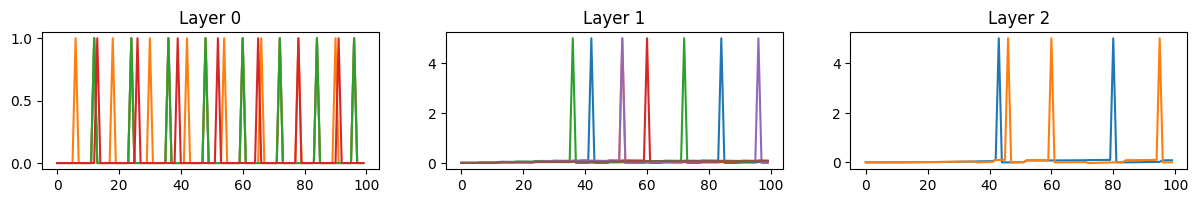

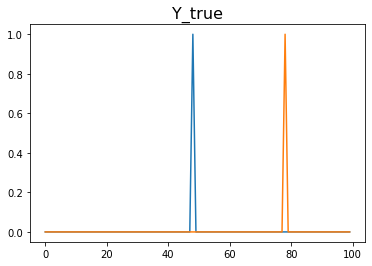

In [0]:
evaluate(vector=parents[0], threshold=0.1, Cm=10)

##Parallel GA

Generation :  1 / 50
Mean Train Error by entire population: 46.941347614724265
Mean Test Error by entire population: 47.540824522771615
Computation Time taken:  553.3295969963074

Random evaluation by best parameter found so far:
Evaluation Error: 42.15447781671598


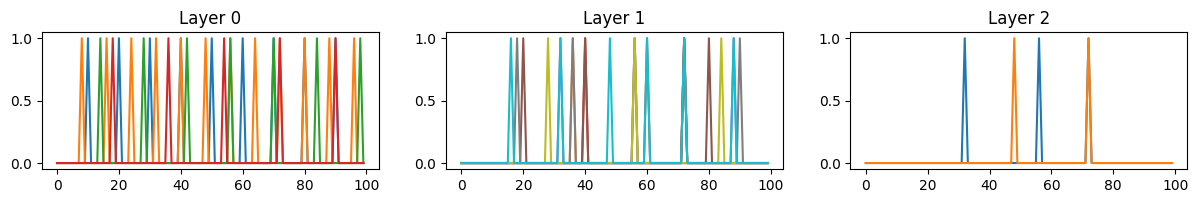

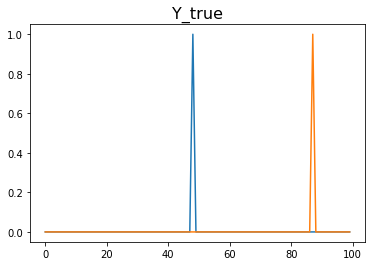

Generation :  2 / 50


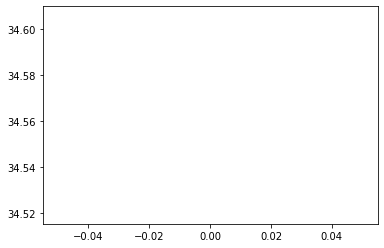

Mean Train Error by best parameters found: 34.60552552828266
Mean Test Error by best parameters found: 34.51973126843806

Mean Train Error by entire population: 50.12033627670267
Mean Test Error by entire population: 50.56385383135218
Computation Time taken:  558.8849494457245

Random evaluation by best parameter found so far:
Evaluation Error: 13.416407864998739


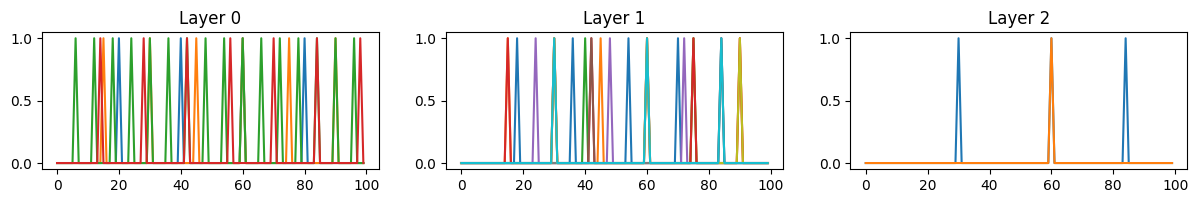

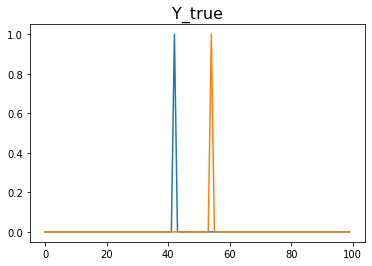

Generation :  3 / 50


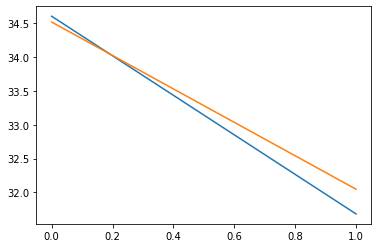

Mean Train Error by best parameters found: 31.681069436187673
Mean Test Error by best parameters found: 32.04659209861803

Mean Train Error by entire population: 53.143693503793656
Mean Test Error by entire population: 53.35619223861437
Computation Time taken:  564.0773129463196

Random evaluation by best parameter found so far:
Evaluation Error: 5.0990195135927845


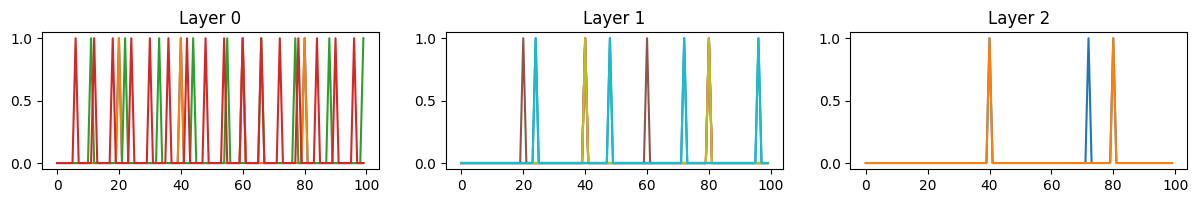

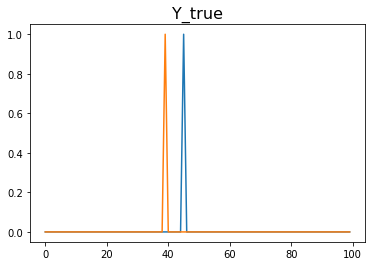

Generation :  4 / 50


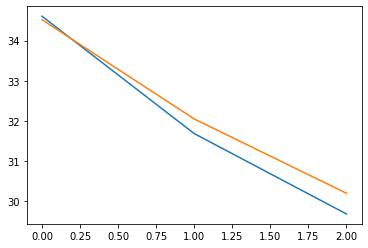

Mean Train Error by best parameters found: 29.679452637254773
Mean Test Error by best parameters found: 30.195729983864837

Mean Train Error by entire population: 48.59866150708779
Mean Test Error by entire population: 48.47406671926586
Computation Time taken:  567.9400639533997

Random evaluation by best parameter found so far:
Evaluation Error: 54.405882034941776


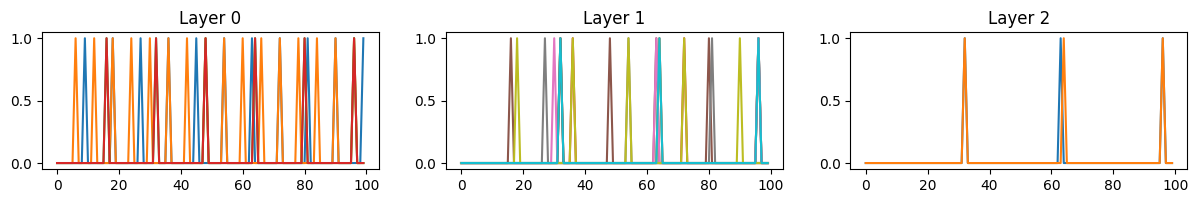

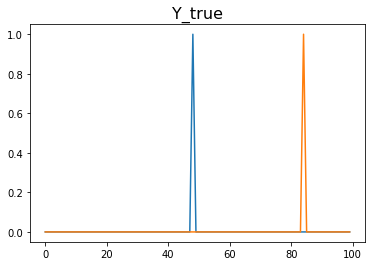

Generation :  5 / 50


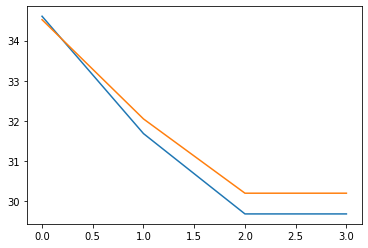

Mean Train Error by best parameters found: 29.679452637254773
Mean Test Error by best parameters found: 30.195729983864837

Mean Train Error by entire population: 45.288910569336025
Mean Test Error by entire population: 45.39960930520654
Computation Time taken:  565.7801764011383

Random evaluation by best parameter found so far:
Evaluation Error: 19.849433241279208


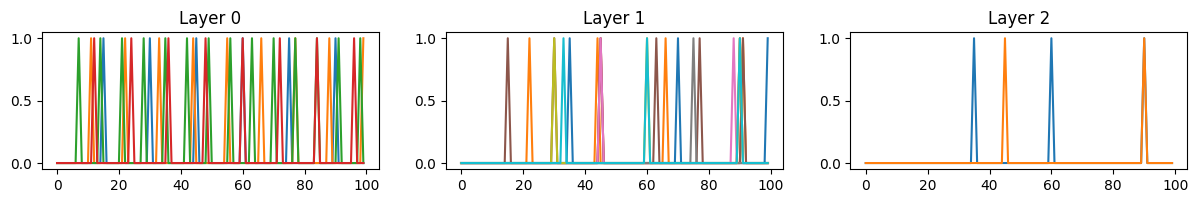

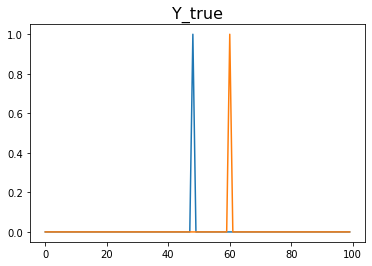

Generation :  6 / 50


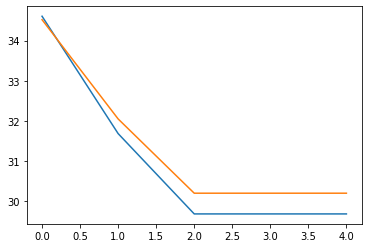

Mean Train Error by best parameters found: 29.679452637254773
Mean Test Error by best parameters found: 30.195729983864837

Mean Train Error by entire population: 55.88277719108917
Mean Test Error by entire population: 55.99417914646304
Computation Time taken:  571.8953759670258

Random evaluation by best parameter found so far:
Evaluation Error: 37.94733192202055


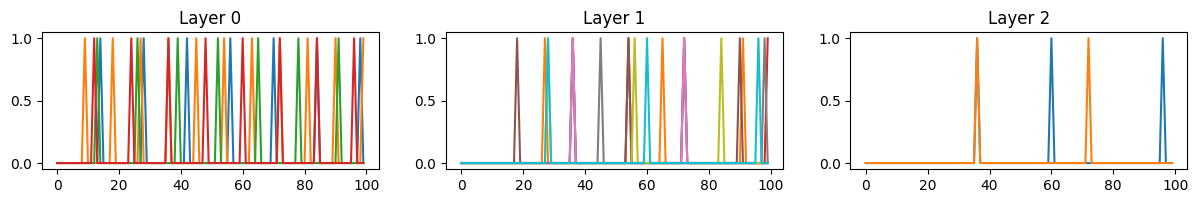

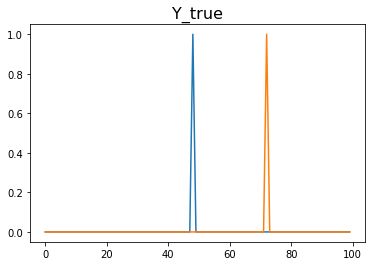

Generation :  7 / 50


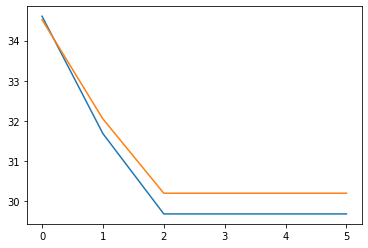

Mean Train Error by best parameters found: 29.679452637254773
Mean Test Error by best parameters found: 30.195729983864837

Mean Train Error by entire population: 47.00780882472401
Mean Test Error by entire population: 47.23489518685005
Computation Time taken:  568.291092634201

Random evaluation by best parameter found so far:
Evaluation Error: 35.90264614203248


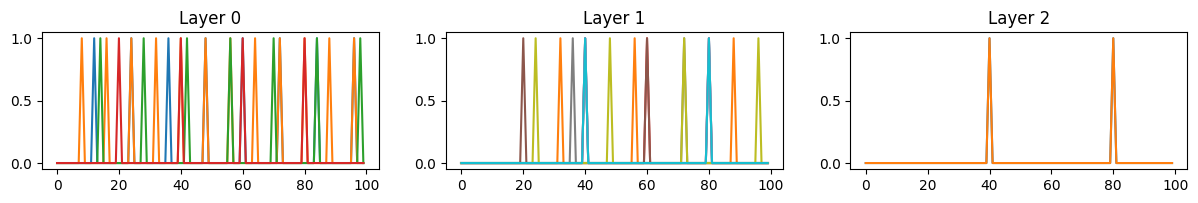

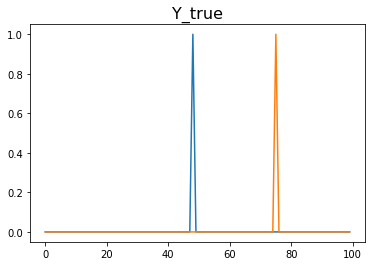

Generation :  8 / 50


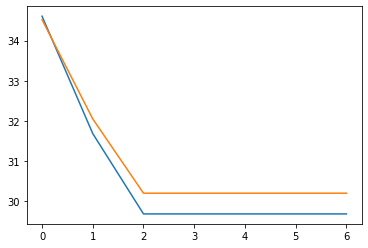

Mean Train Error by best parameters found: 29.679452637254773
Mean Test Error by best parameters found: 30.195729983864837

Mean Train Error by entire population: 60.281995782853194
Mean Test Error by entire population: 60.06369071477713
Computation Time taken:  573.1665439605713

Random evaluation by best parameter found so far:
Evaluation Error: 27.65863337187866


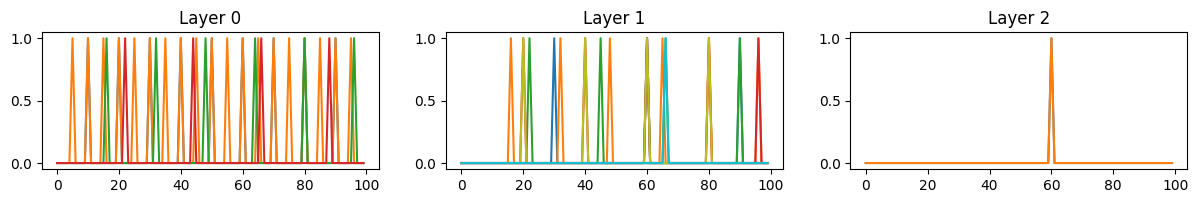

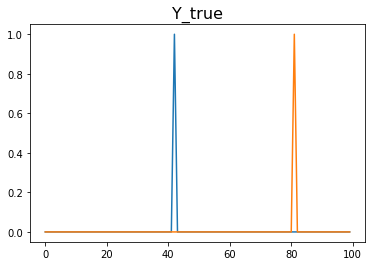

Generation :  9 / 50


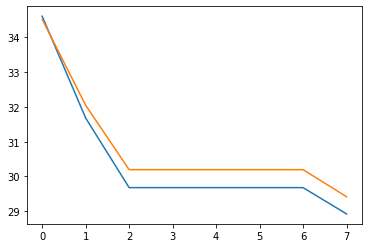

Mean Train Error by best parameters found: 28.923611880049886
Mean Test Error by best parameters found: 29.41844295830985

Mean Train Error by entire population: 40.70466628552623
Mean Test Error by entire population: 41.24569579728623
Computation Time taken:  573.7440230846405

Random evaluation by best parameter found so far:
Evaluation Error: 10.0


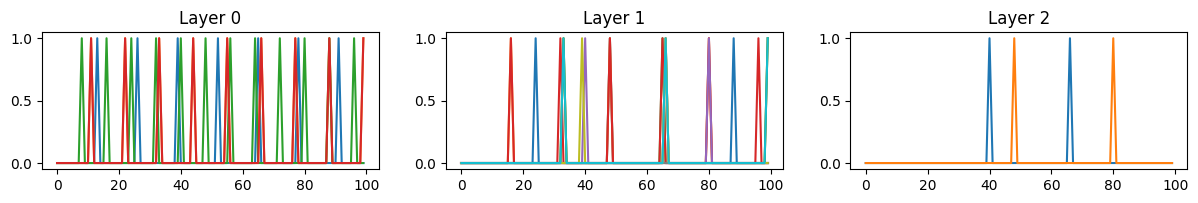

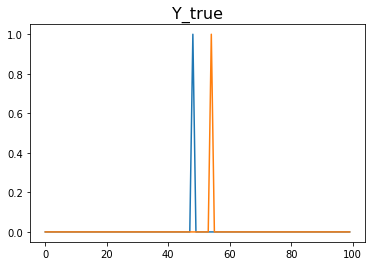

Generation :  10 / 50


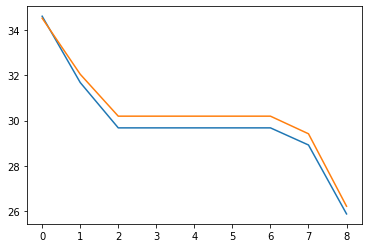

Mean Train Error by best parameters found: 25.881869773263602
Mean Test Error by best parameters found: 26.220465248971994

Mean Train Error by entire population: 43.74040190164517
Mean Test Error by entire population: 44.182176011284334
Computation Time taken:  572.7542161941528

Random evaluation by best parameter found so far:
Evaluation Error: 30.463092423455635


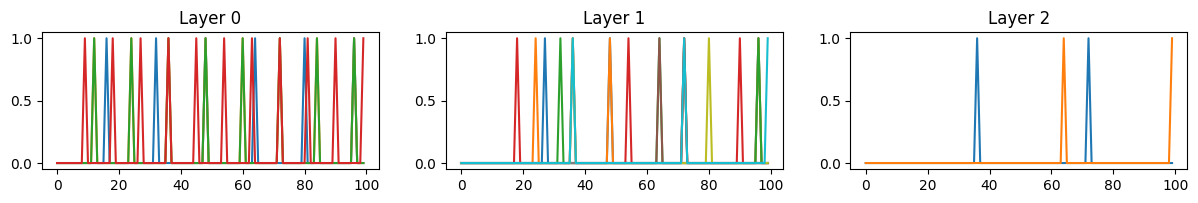

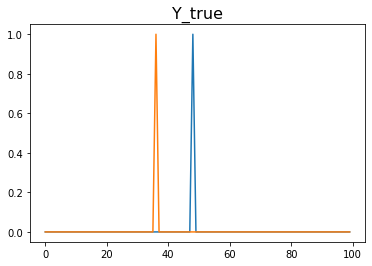

Generation :  11 / 50


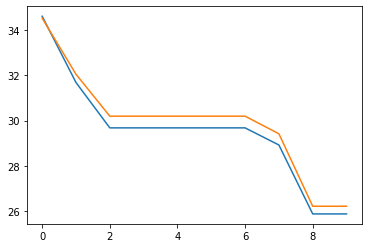

Mean Train Error by best parameters found: 25.881869773263602
Mean Test Error by best parameters found: 26.220465248971994

Mean Train Error by entire population: 55.10207937640782
Mean Test Error by entire population: 55.22321243770588
Computation Time taken:  566.4837801456451

Random evaluation by best parameter found so far:
Evaluation Error: 22.80350850198276


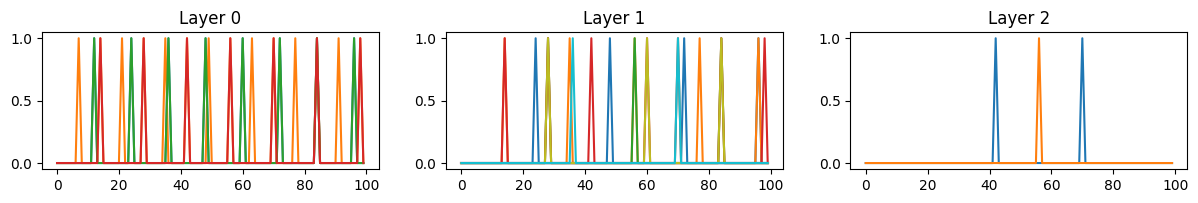

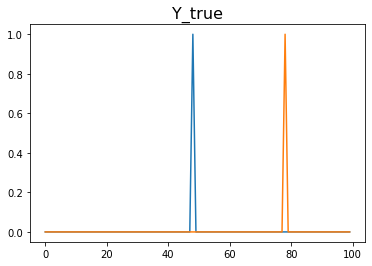

Generation :  12 / 50


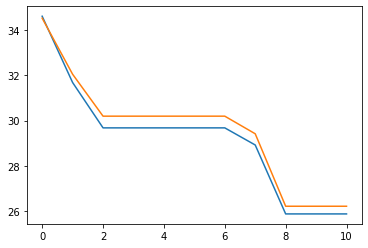

Mean Train Error by best parameters found: 25.881869773263602
Mean Test Error by best parameters found: 26.220465248971994

Mean Train Error by entire population: 40.44236502267171
Mean Test Error by entire population: 40.891788032376255
Computation Time taken:  569.0552756786346

Random evaluation by best parameter found so far:
Evaluation Error: 61.61168720299745


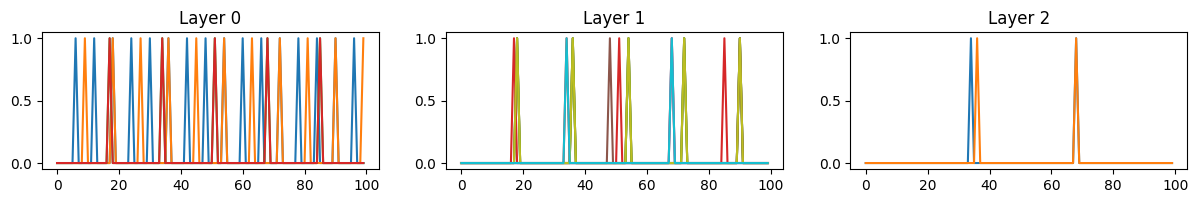

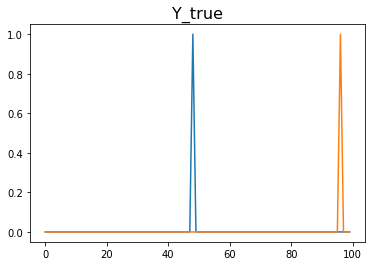

Generation :  13 / 50


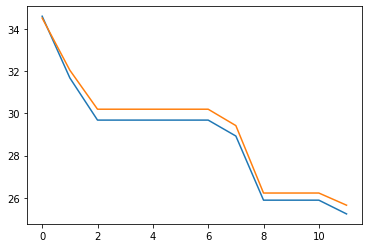

Mean Train Error by best parameters found: 25.229728710893305
Mean Test Error by best parameters found: 25.64312561713832

Mean Train Error by entire population: 44.901125890916994
Mean Test Error by entire population: 45.16274478842654
Computation Time taken:  566.5746552944183

Random evaluation by best parameter found so far:
Evaluation Error: 16.0


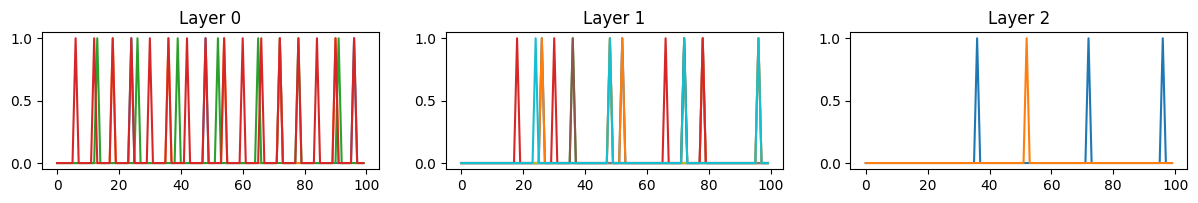

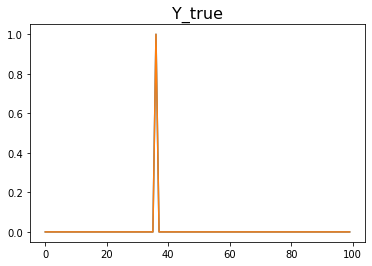

Generation :  14 / 50


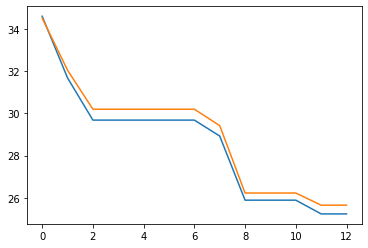

Mean Train Error by best parameters found: 25.229728710893305
Mean Test Error by best parameters found: 25.64312561713832

Mean Train Error by entire population: 43.74510297904824
Mean Test Error by entire population: 44.09975128457231
Computation Time taken:  570.8872218132019

Random evaluation by best parameter found so far:
Evaluation Error: 53.150729063673246


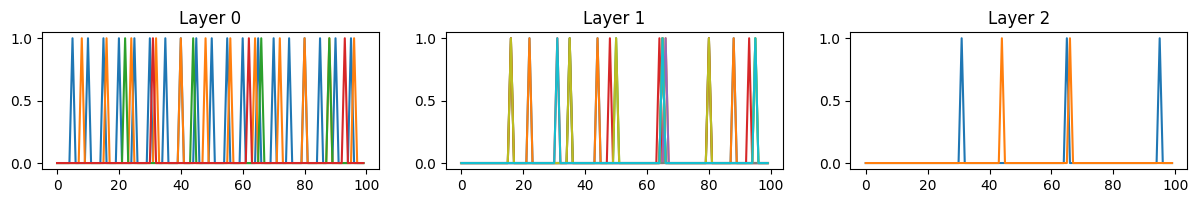

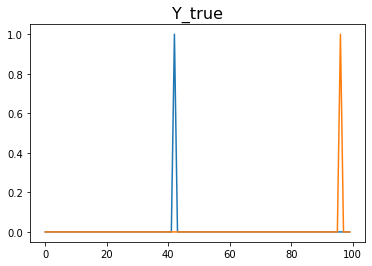

Generation :  15 / 50


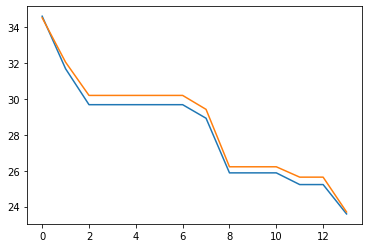

Mean Train Error by best parameters found: 23.595226867612137
Mean Test Error by best parameters found: 23.704356561284275

Mean Train Error by entire population: 34.582744356778036
Mean Test Error by entire population: 35.03386425460549
Computation Time taken:  564.0450458526611

Random evaluation by best parameter found so far:
Evaluation Error: 28.653097563788805


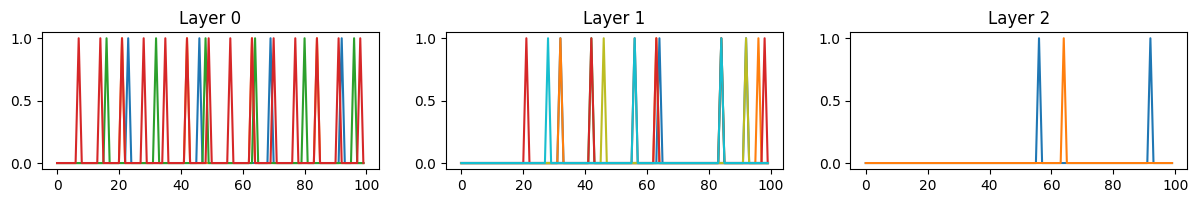

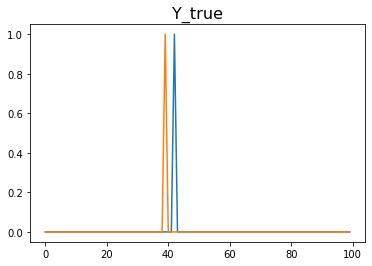

Generation :  16 / 50


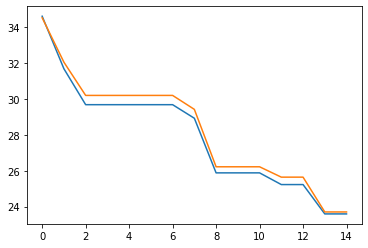

Mean Train Error by best parameters found: 23.595226867612137
Mean Test Error by best parameters found: 23.704356561284275

Mean Train Error by entire population: 52.74315410836632
Mean Test Error by entire population: 53.23757683289017
Computation Time taken:  576.1846899986267

Random evaluation by best parameter found so far:
Evaluation Error: 9.486832980505138


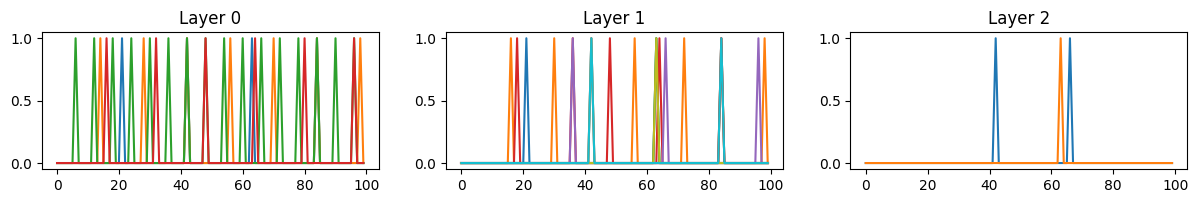

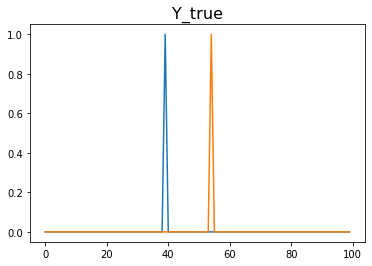

Generation :  17 / 50


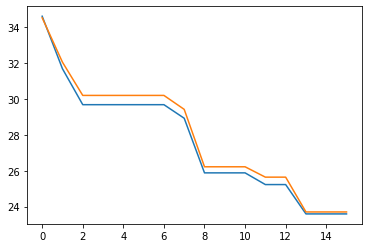

Mean Train Error by best parameters found: 23.595226867612137
Mean Test Error by best parameters found: 23.704356561284275

Mean Train Error by entire population: 45.515372105464024
Mean Test Error by entire population: 45.73547782501174
Computation Time taken:  577.9865052700043

Random evaluation by best parameter found so far:
Evaluation Error: 9.486832980505138


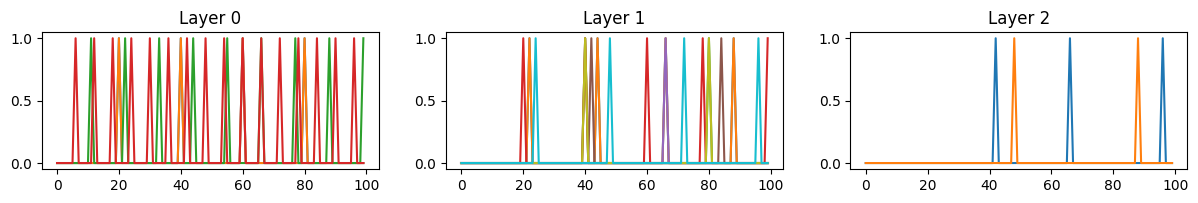

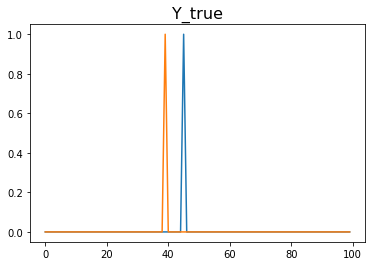

Generation :  18 / 50


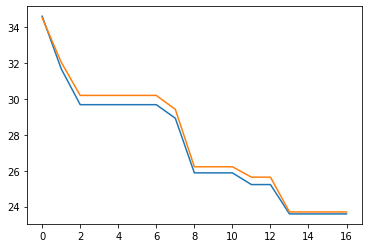

Mean Train Error by best parameters found: 23.595226867612137
Mean Test Error by best parameters found: 23.704356561284275

Mean Train Error by entire population: 36.4569228695864
Mean Test Error by entire population: 36.66291185797139
Computation Time taken:  568.0152850151062

Random evaluation by best parameter found so far:
Evaluation Error: 17.88854381999832


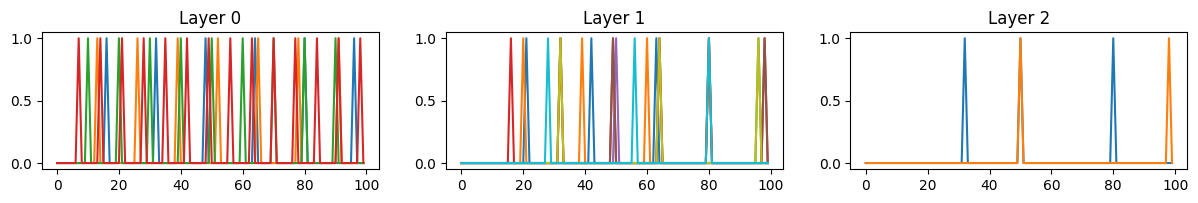

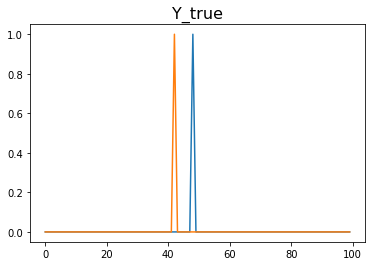

Generation :  19 / 50


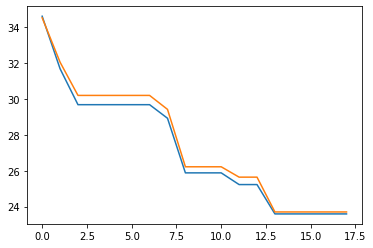

Mean Train Error by best parameters found: 23.595226867612137
Mean Test Error by best parameters found: 23.704356561284275

Mean Train Error by entire population: 53.204210196070896
Mean Test Error by entire population: 53.33156655387457
Computation Time taken:  565.9824323654175

Random evaluation by best parameter found so far:
Evaluation Error: 49.36598018878993


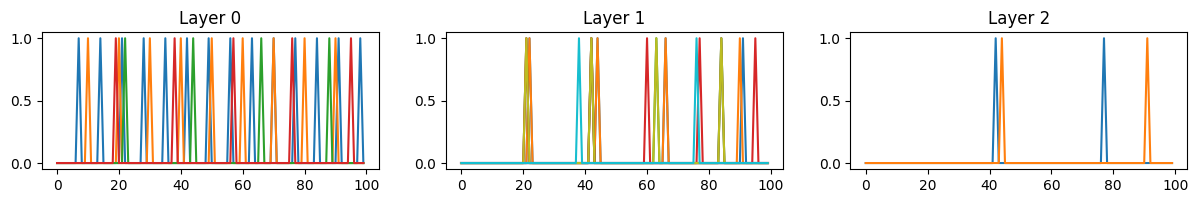

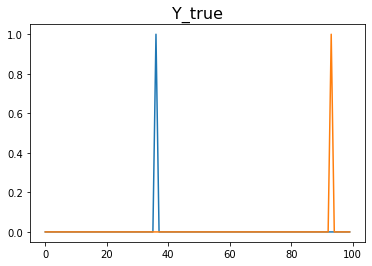

Generation :  20 / 50


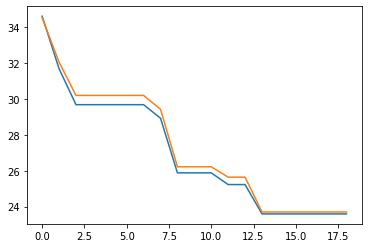

Mean Train Error by best parameters found: 23.595226867612137
Mean Test Error by best parameters found: 23.704356561284275

Mean Train Error by entire population: 38.079635109215225
Mean Test Error by entire population: 38.15383806653192
Computation Time taken:  560.0568749904633

Random evaluation by best parameter found so far:
Evaluation Error: 10.816653826391969


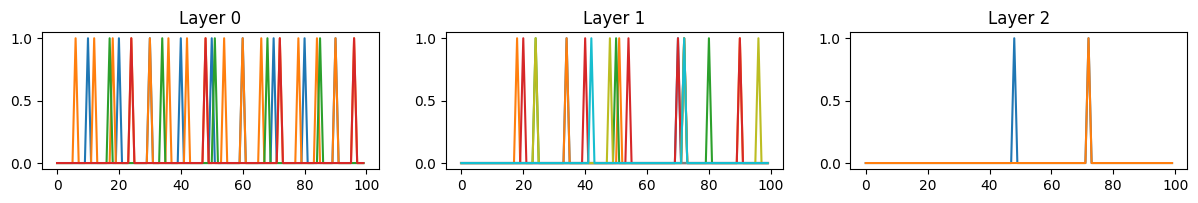

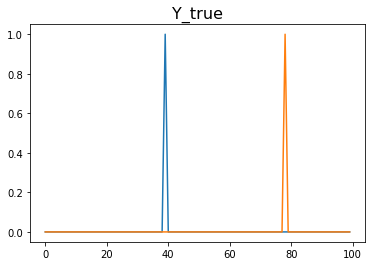

Generation :  21 / 50


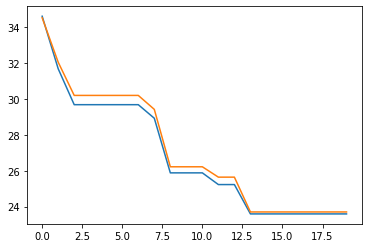

Mean Train Error by best parameters found: 23.595226867612137
Mean Test Error by best parameters found: 23.704356561284275

Mean Train Error by entire population: 48.26287255724658
Mean Test Error by entire population: 48.324736829767375
Computation Time taken:  560.7971661090851

Random evaluation by best parameter found so far:
Evaluation Error: 48.27007354458868


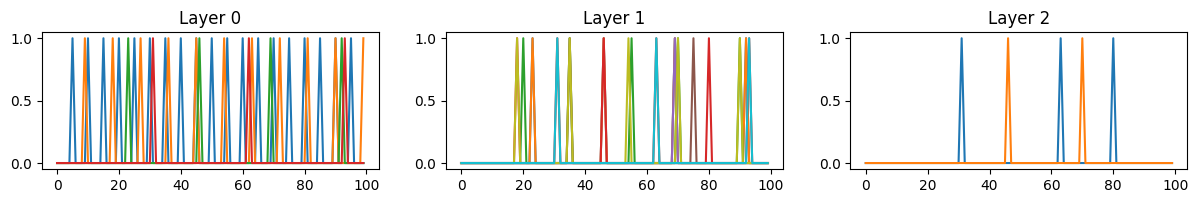

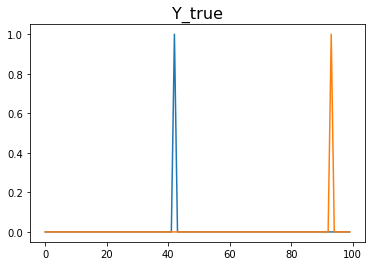

Generation :  22 / 50


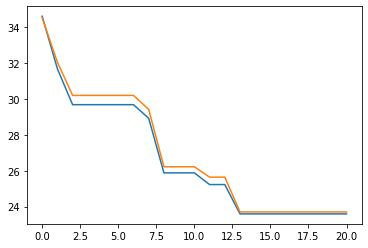

Mean Train Error by best parameters found: 23.595226867612137
Mean Test Error by best parameters found: 23.704356561284275

Mean Train Error by entire population: 63.017925795971635
Mean Test Error by entire population: 63.24751856341625
Computation Time taken:  565.0587227344513

Random evaluation by best parameter found so far:
Evaluation Error: 47.12748667179272


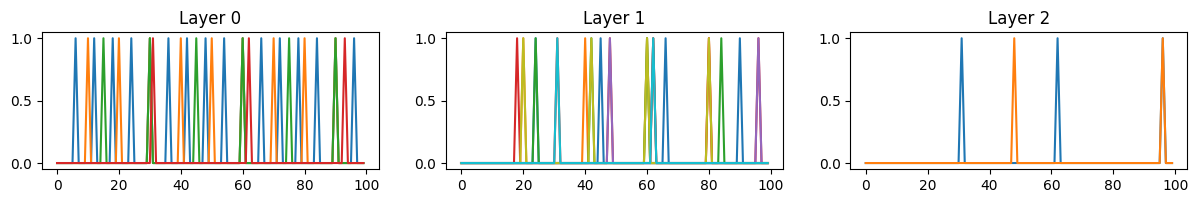

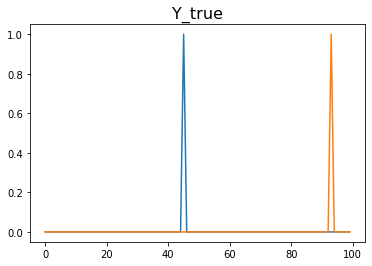

Generation :  23 / 50


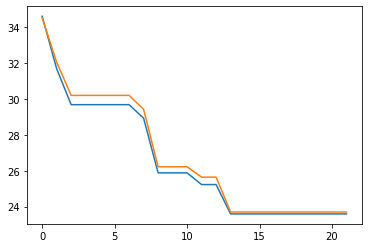

Mean Train Error by best parameters found: 23.595226867612137
Mean Test Error by best parameters found: 23.704356561284275

Mean Train Error by entire population: 64.37706427467647
Mean Test Error by entire population: 63.98349430134756
Computation Time taken:  564.7440745830536

Random evaluation by best parameter found so far:
Evaluation Error: 15.0


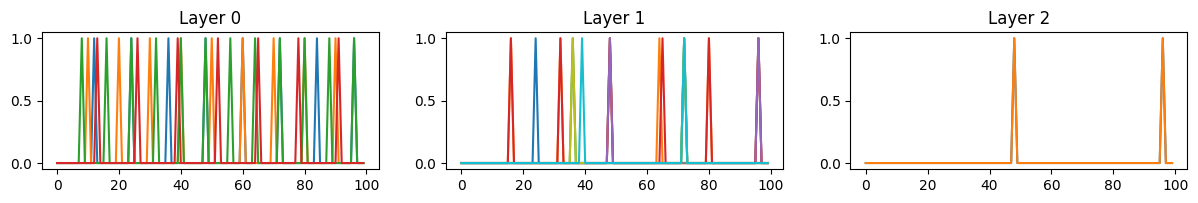

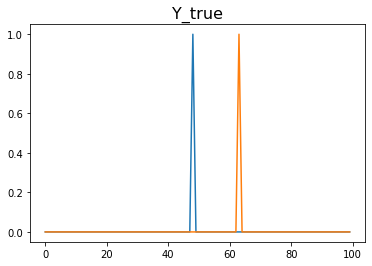

Generation :  24 / 50


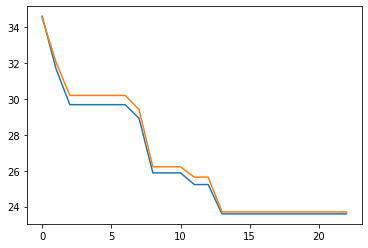

Mean Train Error by best parameters found: 23.595226867612137
Mean Test Error by best parameters found: 23.704356561284275

Mean Train Error by entire population: 58.14147402297993
Mean Test Error by entire population: 57.908010135527604
Computation Time taken:  564.363454580307

Random evaluation by best parameter found so far:
Evaluation Error: 15.0


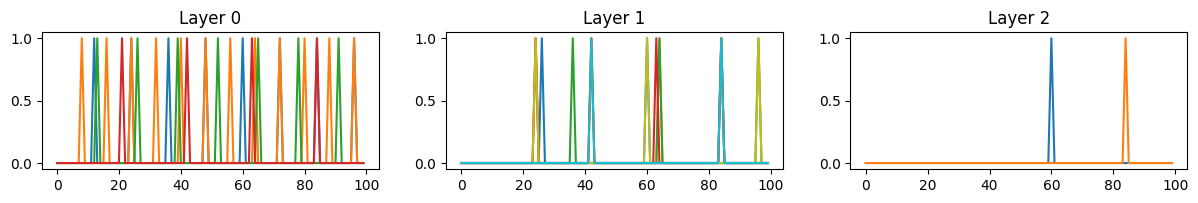

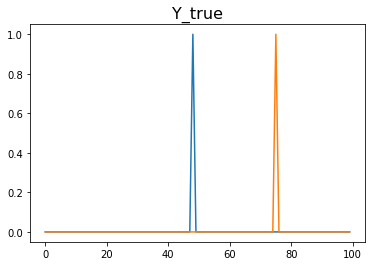

Generation :  25 / 50


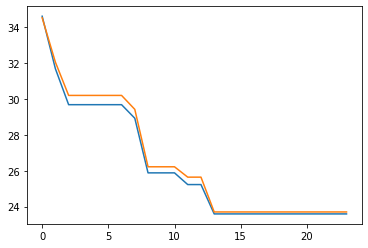

Mean Train Error by best parameters found: 23.595226867612137
Mean Test Error by best parameters found: 23.704356561284275

Mean Train Error by entire population: 56.30499653564471
Mean Test Error by entire population: 56.48134832812713
Computation Time taken:  568.8757271766663

Random evaluation by best parameter found so far:
Evaluation Error: 13.416407864998739


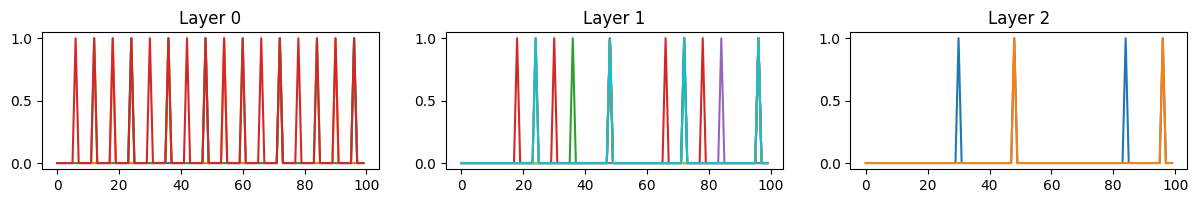

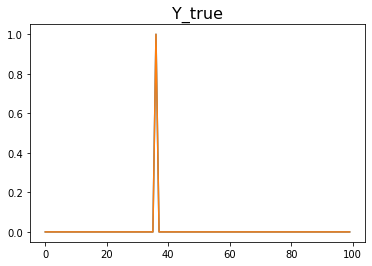

Generation :  26 / 50


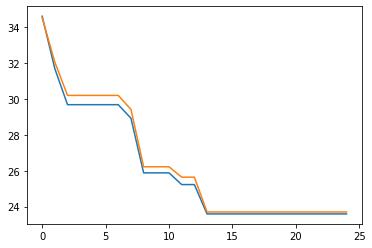

Mean Train Error by best parameters found: 23.595226867612137
Mean Test Error by best parameters found: 23.704356561284275

Mean Train Error by entire population: 55.71566047738282
Mean Test Error by entire population: 55.61403944810039
Computation Time taken:  573.6274852752686

Random evaluation by best parameter found so far:
Evaluation Error: 48.507731342539614


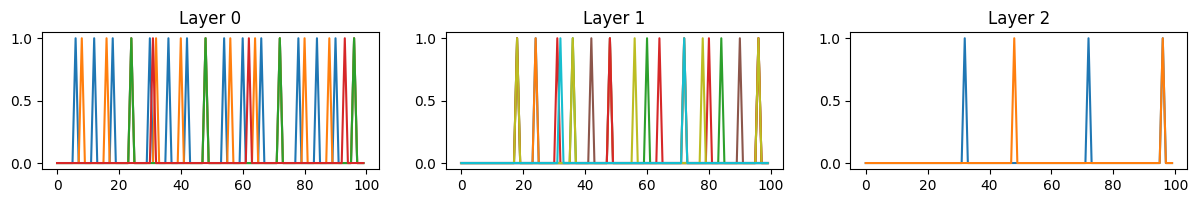

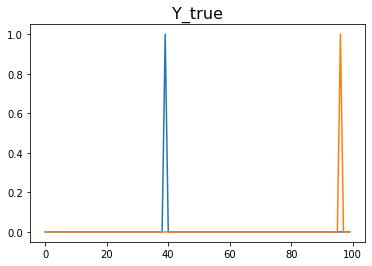

Generation :  27 / 50


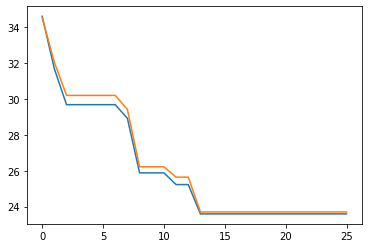

Mean Train Error by best parameters found: 23.595226867612137
Mean Test Error by best parameters found: 23.704356561284275

Mean Train Error by entire population: 42.331717941427776
Mean Test Error by entire population: 42.50928542587059
Computation Time taken:  562.3212549686432

Random evaluation by best parameter found so far:
Evaluation Error: 21.840329667841555


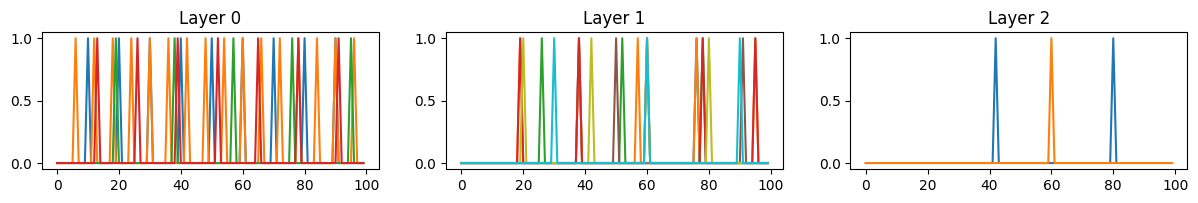

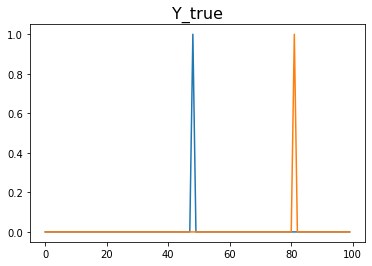

Generation :  28 / 50


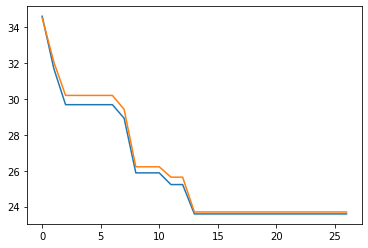

Mean Train Error by best parameters found: 23.595226867612137
Mean Test Error by best parameters found: 23.704356561284275

Mean Train Error by entire population: 52.38989154917497
Mean Test Error by entire population: 52.38715648244104
Computation Time taken:  565.0046060085297

Random evaluation by best parameter found so far:
Evaluation Error: 4.123105625617661


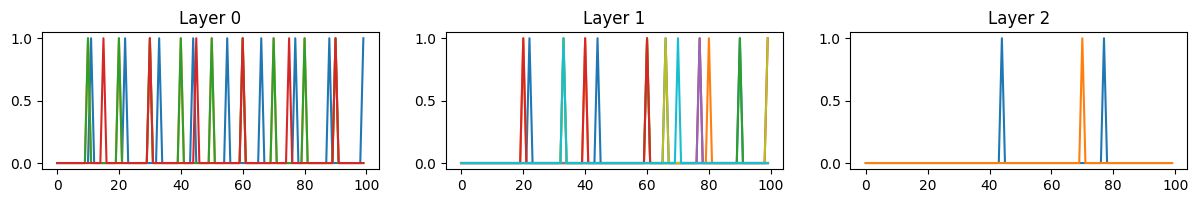

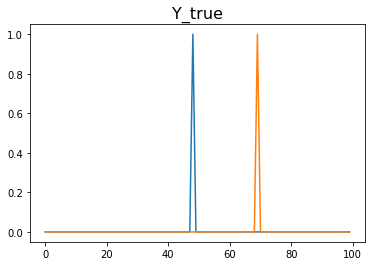

Generation :  29 / 50


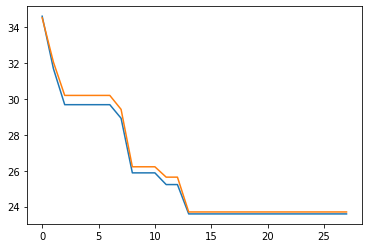

Mean Train Error by best parameters found: 23.595226867612137
Mean Test Error by best parameters found: 23.704356561284275

Mean Train Error by entire population: 64.01683092252803
Mean Test Error by entire population: 64.34443688246022
Computation Time taken:  561.6734807491302

Random evaluation by best parameter found so far:
Evaluation Error: 12.0


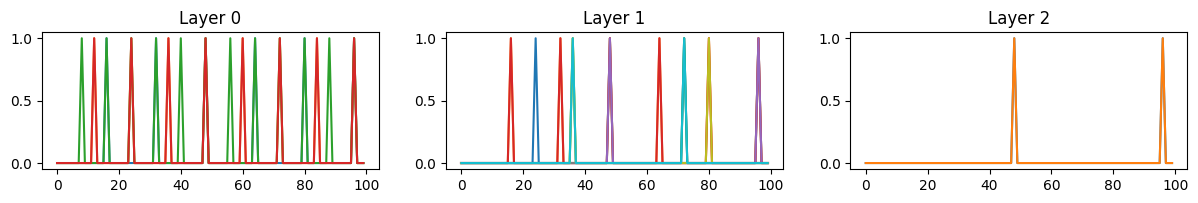

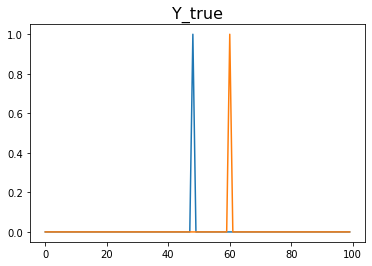

Generation :  30 / 50


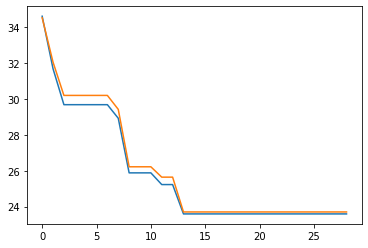

Mean Train Error by best parameters found: 23.595226867612137
Mean Test Error by best parameters found: 23.704356561284275

Mean Train Error by entire population: 54.51023578422486
Mean Test Error by entire population: 54.59651943261591
Computation Time taken:  559.0702705383301

Random evaluation by best parameter found so far:
Evaluation Error: 44.94441010848846


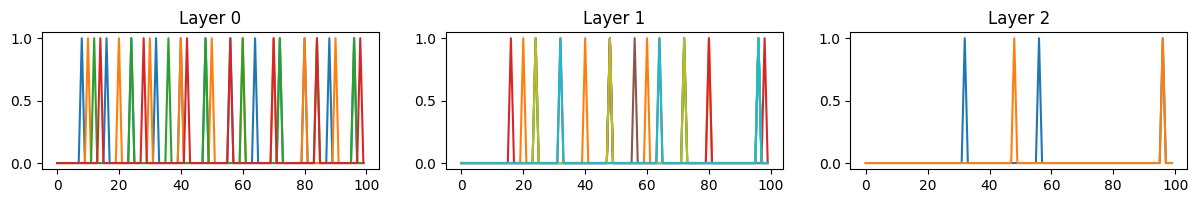

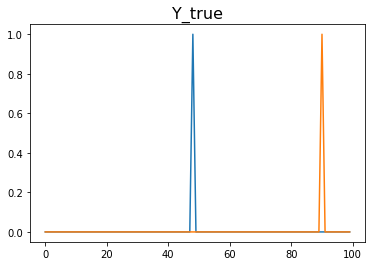

Generation :  31 / 50


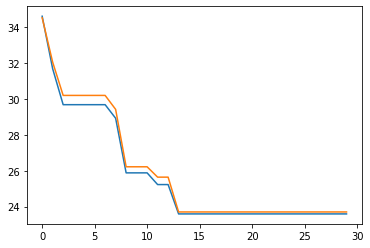

Mean Train Error by best parameters found: 23.595226867612137
Mean Test Error by best parameters found: 23.704356561284275

Mean Train Error by entire population: 51.37680455516124
Mean Test Error by entire population: 51.33984227633835
Computation Time taken:  557.1124198436737

Random evaluation by best parameter found so far:
Evaluation Error: 23.600847442411894


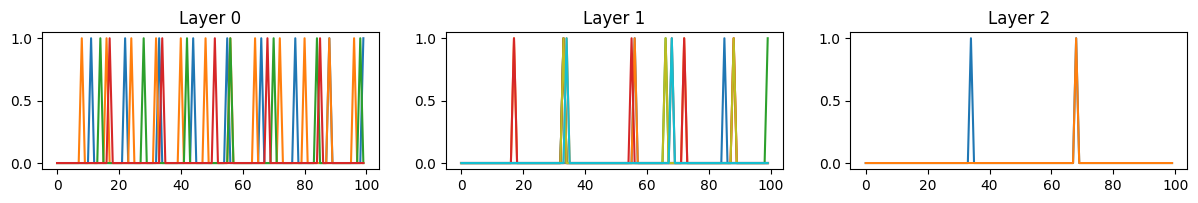

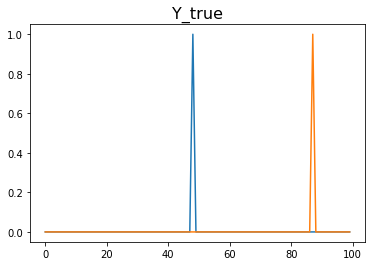

Generation :  32 / 50


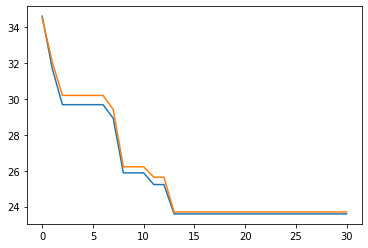

Mean Train Error by best parameters found: 23.595226867612137
Mean Test Error by best parameters found: 23.704356561284275

Mean Train Error by entire population: 44.827040139071954
Mean Test Error by entire population: 44.98701765756443
Computation Time taken:  555.363205909729

Random evaluation by best parameter found so far:
Evaluation Error: 19.209372712298546


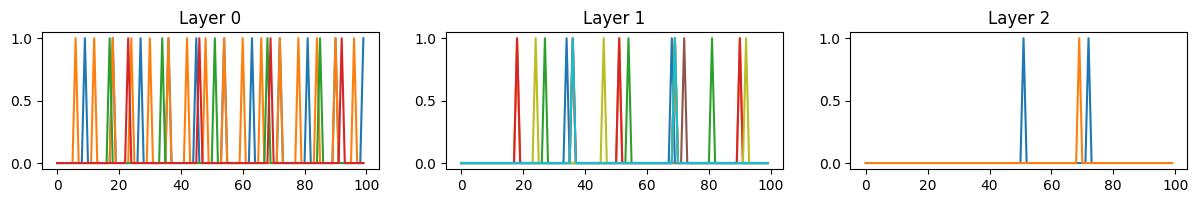

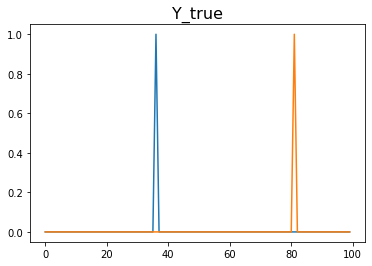

Generation :  33 / 50


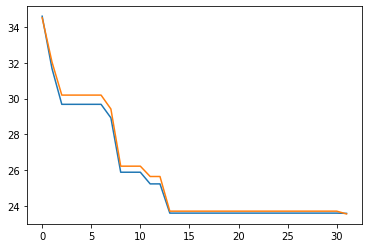

Mean Train Error by best parameters found: 23.58007278369778
Mean Test Error by best parameters found: 23.550333983458795

Mean Train Error by entire population: 34.10512953226535
Mean Test Error by entire population: 34.031619309131024
Computation Time taken:  561.992395401001

Random evaluation by best parameter found so far:
Evaluation Error: 44.94441010848846


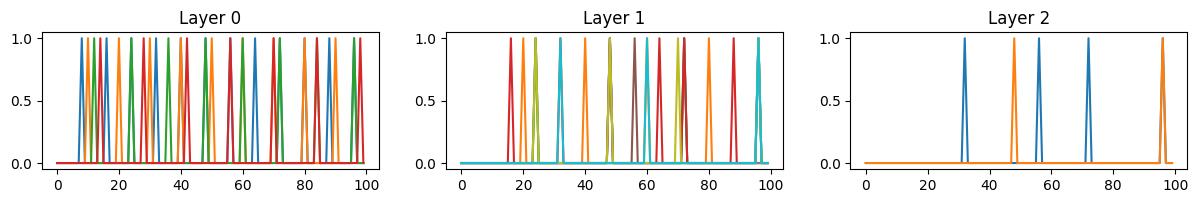

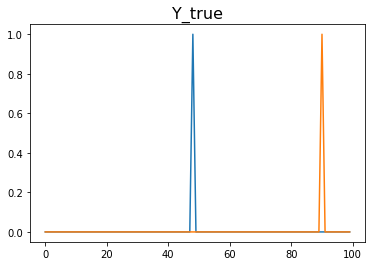

Generation :  34 / 50


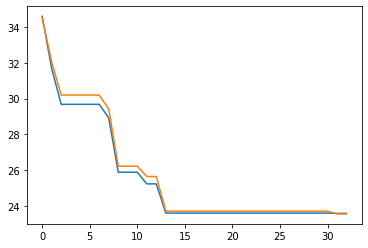

Mean Train Error by best parameters found: 23.58007278369778
Mean Test Error by best parameters found: 23.550333983458795

Mean Train Error by entire population: 43.39456444097628
Mean Test Error by entire population: 43.742481928621835
Computation Time taken:  564.2852666378021

Random evaluation by best parameter found so far:
Evaluation Error: 17.08800749063506


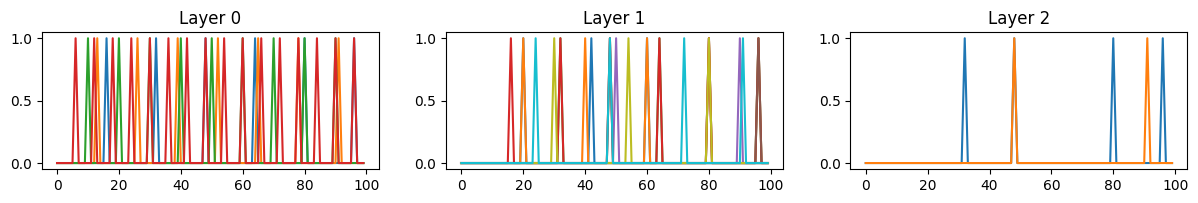

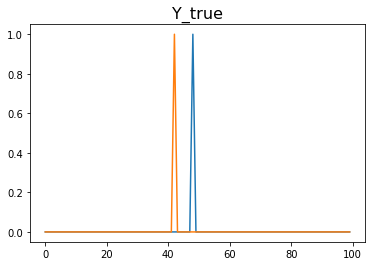

Generation :  35 / 50


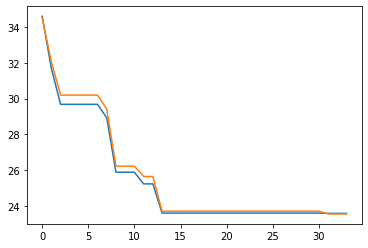

Mean Train Error by best parameters found: 23.58007278369778
Mean Test Error by best parameters found: 23.550333983458795

Mean Train Error by entire population: 47.338241849707536
Mean Test Error by entire population: 47.34077008334382
Computation Time taken:  557.2862076759338

Random evaluation by best parameter found so far:
Evaluation Error: 12.0


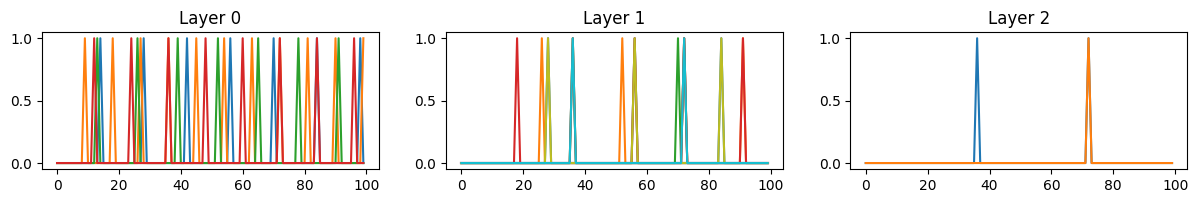

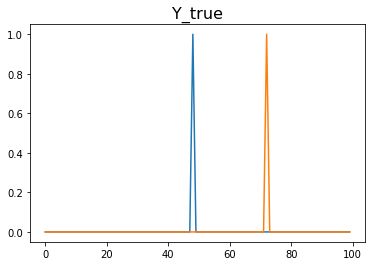

Generation :  36 / 50


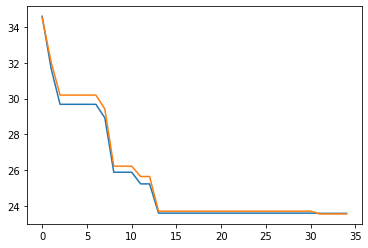

Mean Train Error by best parameters found: 23.58007278369778
Mean Test Error by best parameters found: 23.550333983458795

Mean Train Error by entire population: 55.01702699000221
Mean Test Error by entire population: 55.225663493482514
Computation Time taken:  560.7402925491333

Random evaluation by best parameter found so far:
Evaluation Error: 13.601470508735444


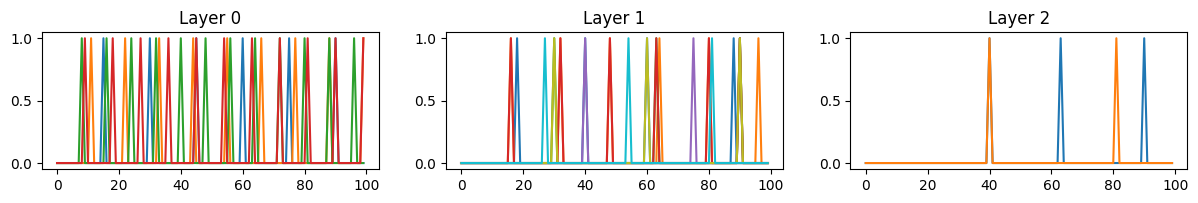

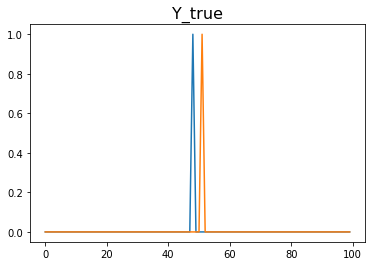

Generation :  37 / 50


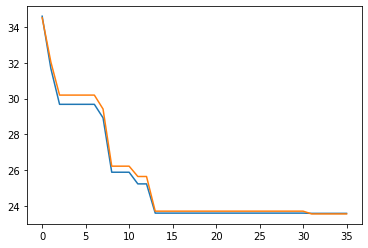

Mean Train Error by best parameters found: 23.58007278369778
Mean Test Error by best parameters found: 23.550333983458795

Mean Train Error by entire population: 53.342518133109216
Mean Test Error by entire population: 53.463662460855524
Computation Time taken:  559.6278901100159

Random evaluation by best parameter found so far:
Evaluation Error: 9.486832980505138


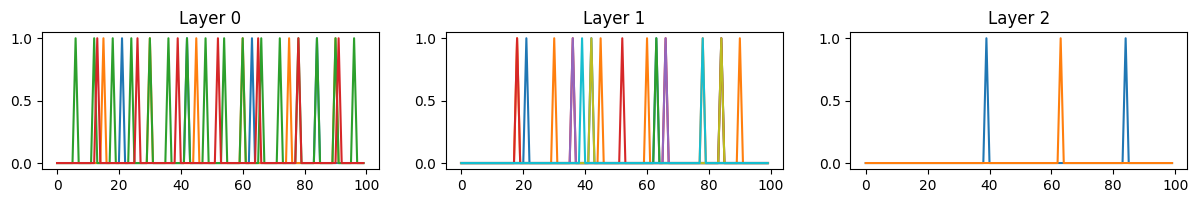

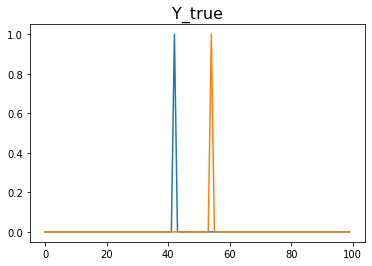

Generation :  38 / 50


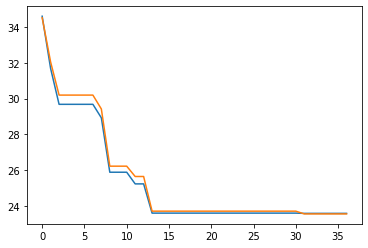

Mean Train Error by best parameters found: 23.58007278369778
Mean Test Error by best parameters found: 23.550333983458795

Mean Train Error by entire population: 45.56725457201329
Mean Test Error by entire population: 45.75428587455596
Computation Time taken:  557.8824737071991

Random evaluation by best parameter found so far:
Evaluation Error: 9.486832980505138


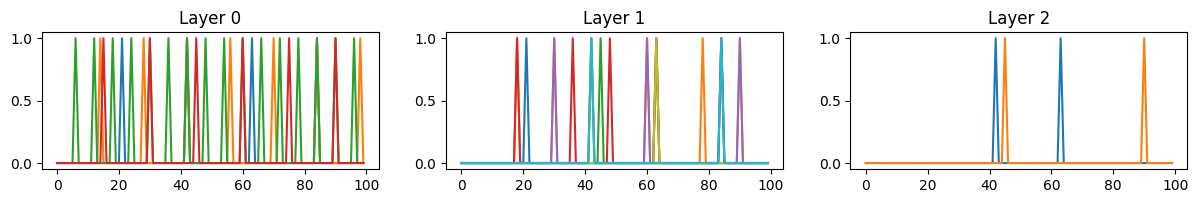

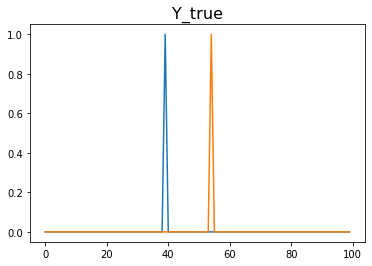

Generation :  39 / 50


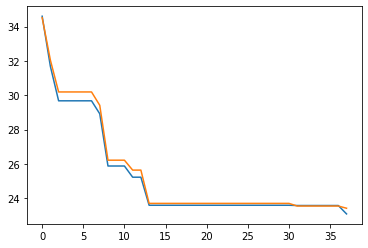

Mean Train Error by best parameters found: 23.09097110093255
Mean Test Error by best parameters found: 23.42235539425403

Mean Train Error by entire population: 60.9345247120868
Mean Test Error by entire population: 61.0149642271319
Computation Time taken:  562.717029094696

Random evaluation by best parameter found so far:
Evaluation Error: 30.463092423455635


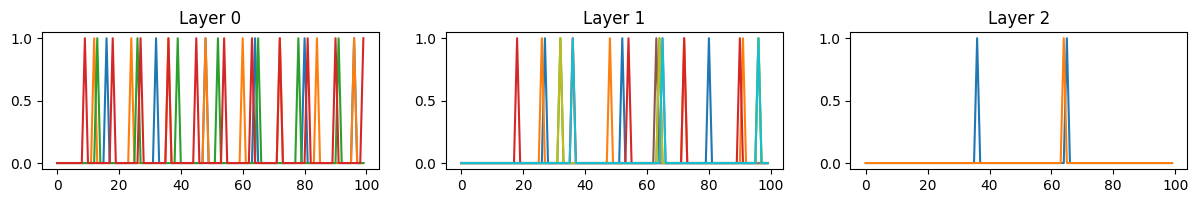

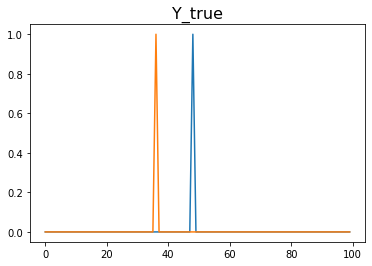

Generation :  40 / 50


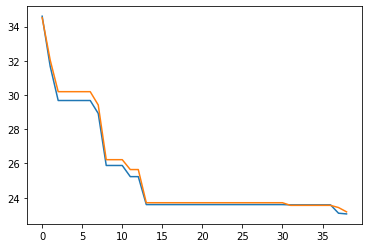

Mean Train Error by best parameters found: 23.050139284265455
Mean Test Error by best parameters found: 23.17156882454104

Mean Train Error by entire population: 42.00727718749703
Mean Test Error by entire population: 42.368720230641244
Computation Time taken:  563.3180367946625

Random evaluation by best parameter found so far:
Evaluation Error: 6.708203932499369


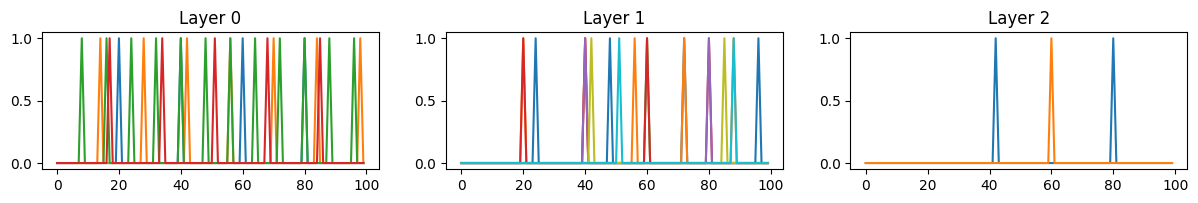

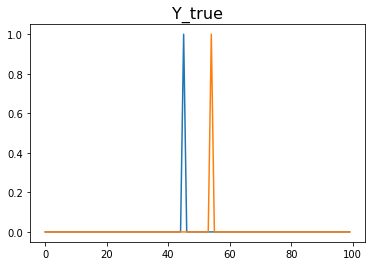

Generation :  41 / 50


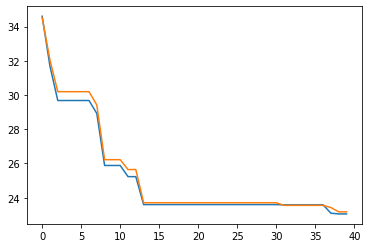

Mean Train Error by best parameters found: 23.050139284265455
Mean Test Error by best parameters found: 23.17156882454104

Mean Train Error by entire population: 48.05089672819553
Mean Test Error by entire population: 48.12317839916094
Computation Time taken:  570.0978627204895

Random evaluation by best parameter found so far:
Evaluation Error: 4.242640687119285


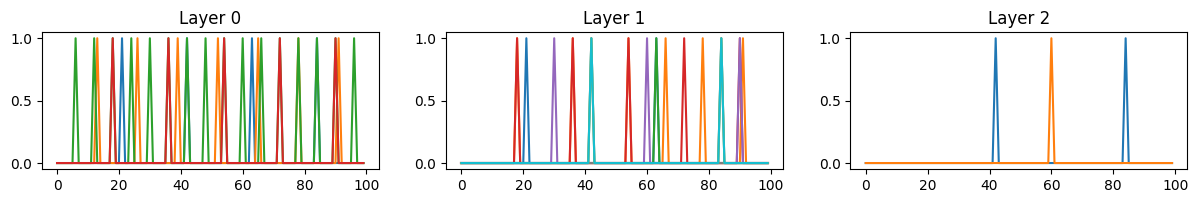

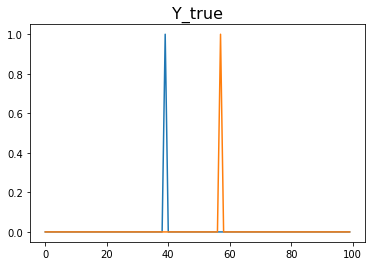

Generation :  42 / 50


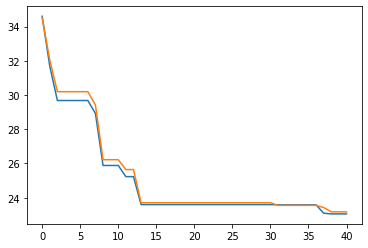

Mean Train Error by best parameters found: 23.050139284265455
Mean Test Error by best parameters found: 23.17156882454104

Mean Train Error by entire population: 47.73738893601845
Mean Test Error by entire population: 48.01552967991685
Computation Time taken:  559.5174040794373

Random evaluation by best parameter found so far:
Evaluation Error: 16.97056274847714


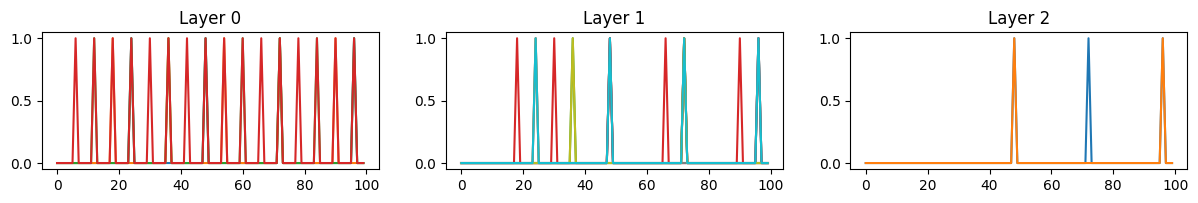

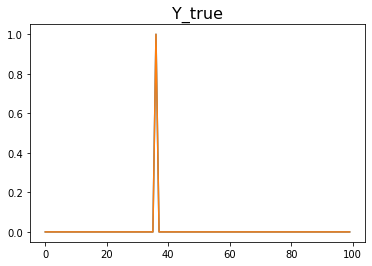

Generation :  43 / 50


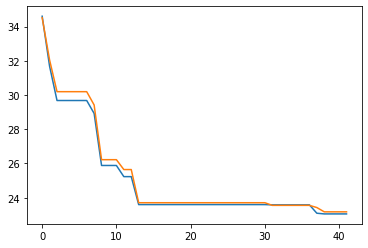

Mean Train Error by best parameters found: 23.050139284265455
Mean Test Error by best parameters found: 23.17156882454104

Mean Train Error by entire population: 40.28427396158359
Mean Test Error by entire population: 40.64557785349222
Computation Time taken:  562.066365480423

Random evaluation by best parameter found so far:
Evaluation Error: 45.09988913511872


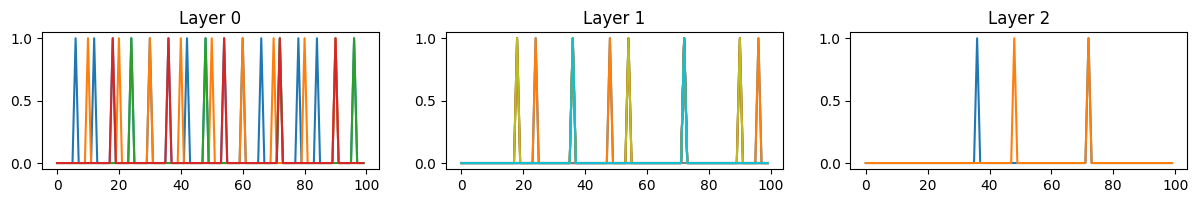

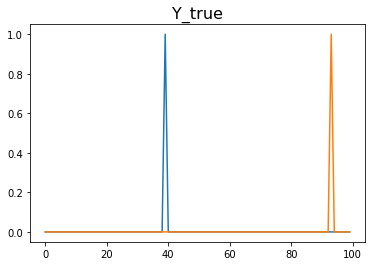

Generation :  44 / 50


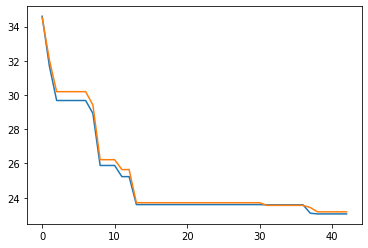

Mean Train Error by best parameters found: 23.050139284265455
Mean Test Error by best parameters found: 23.17156882454104

Mean Train Error by entire population: 47.11276263745336
Mean Test Error by entire population: 47.185355614820594
Computation Time taken:  564.7667832374573

Random evaluation by best parameter found so far:
Evaluation Error: 32.55764119219941


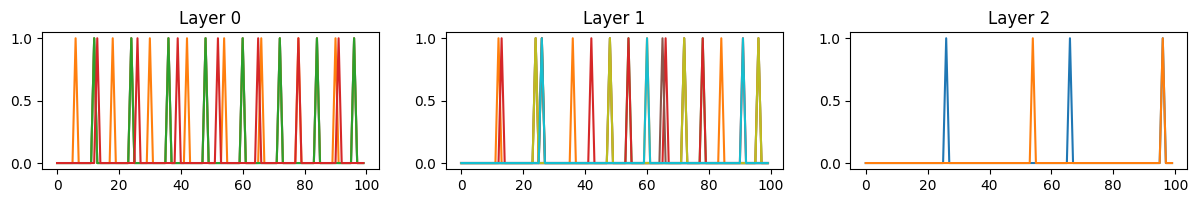

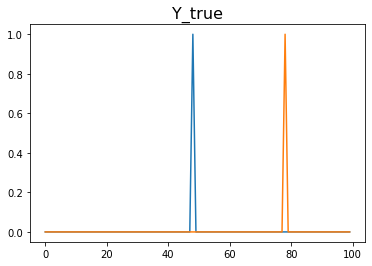

Generation :  45 / 50


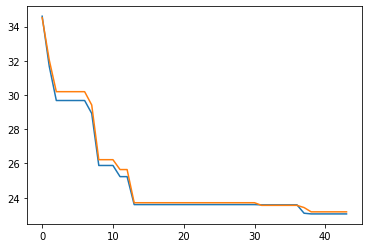

Mean Train Error by best parameters found: 23.050139284265455
Mean Test Error by best parameters found: 23.17156882454104

Mean Train Error by entire population: 59.310463277781174
Mean Test Error by entire population: 58.89097358408239
Computation Time taken:  567.5881402492523

Random evaluation by best parameter found so far:
Evaluation Error: 43.18564576337837


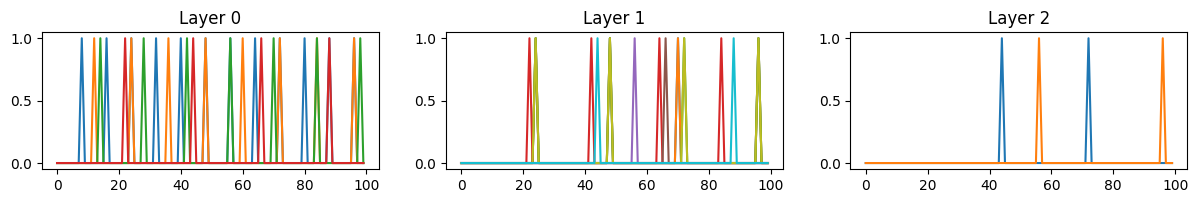

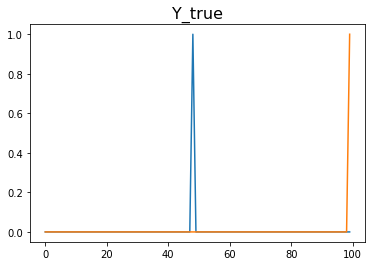

Generation :  46 / 50


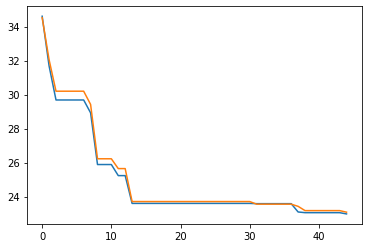

Mean Train Error by best parameters found: 22.97673940568341
Mean Test Error by best parameters found: 23.079164948079544

Mean Train Error by entire population: 40.15180906104192
Mean Test Error by entire population: 40.5096901115173
Computation Time taken:  566.1637125015259

Random evaluation by best parameter found so far:
Evaluation Error: 12.36931687685298


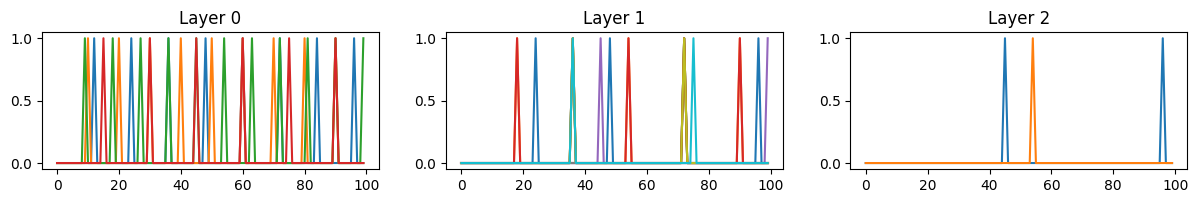

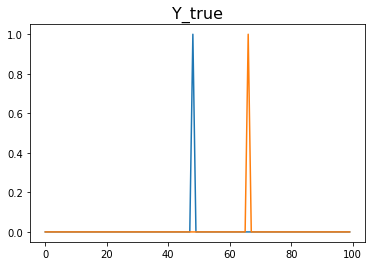

Generation :  47 / 50


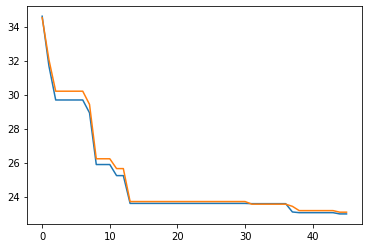

Mean Train Error by best parameters found: 22.97673940568341
Mean Test Error by best parameters found: 23.079164948079544

Mean Train Error by entire population: 42.04354138305125
Mean Test Error by entire population: 42.03271620520719
Computation Time taken:  562.3878104686737

Random evaluation by best parameter found so far:
Evaluation Error: 17.0


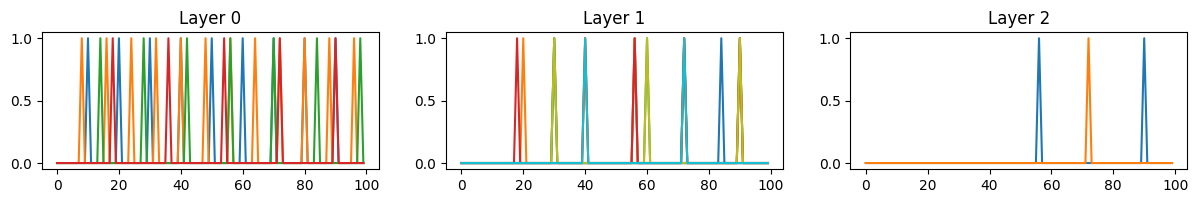

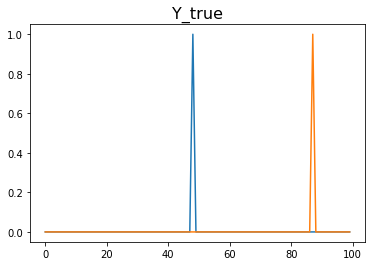

Generation :  48 / 50


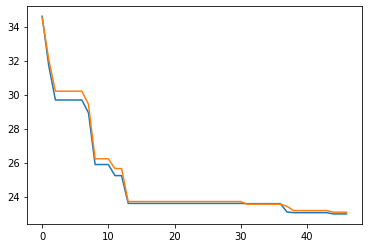

Mean Train Error by best parameters found: 22.97673940568341
Mean Test Error by best parameters found: 23.079164948079544

Mean Train Error by entire population: 43.9776518348247
Mean Test Error by entire population: 44.08394314743569
Computation Time taken:  558.017510175705

Random evaluation by best parameter found so far:
Evaluation Error: 10.816653826391969


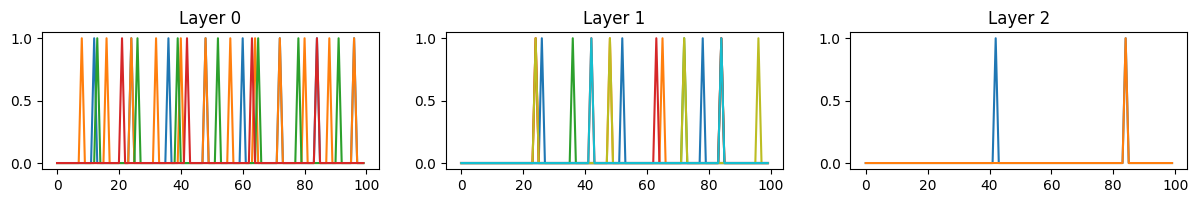

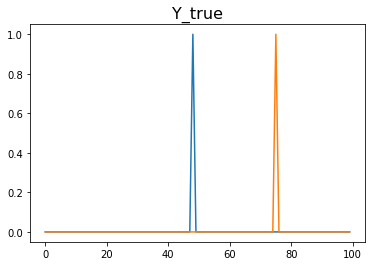

Generation :  49 / 50


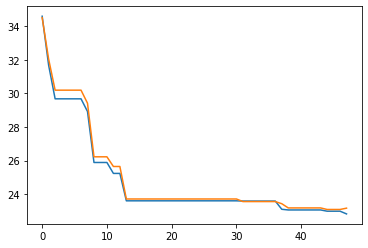

Mean Train Error by best parameters found: 22.81392001496458
Mean Test Error by best parameters found: 23.15721648523217

Mean Train Error by entire population: 38.911166793597886
Mean Test Error by entire population: 39.365527692509005
Computation Time taken:  556.0896079540253

Random evaluation by best parameter found so far:
Evaluation Error: 12.041594578792296


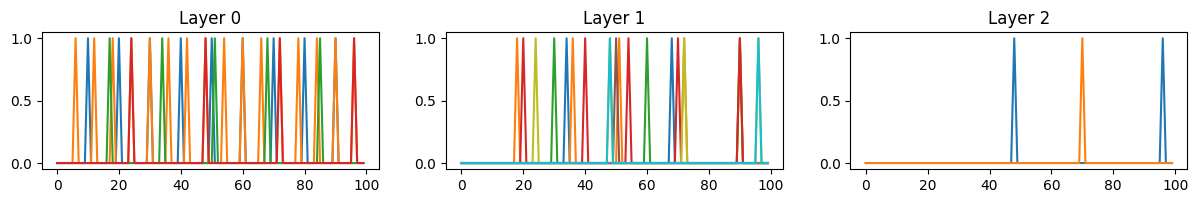

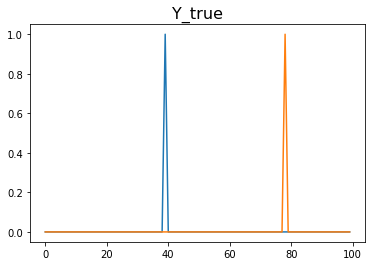

Generation :  50 / 50


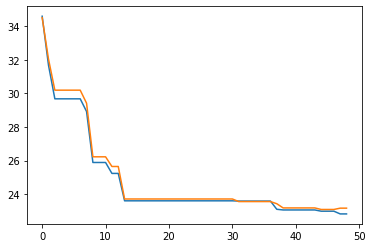

Mean Train Error by best parameters found: 22.81392001496458
Mean Test Error by best parameters found: 23.15721648523217

Mean Train Error by entire population: 45.77207787613859
Mean Test Error by entire population: 45.89910910890711
Computation Time taken:  554.4450261592865

Random evaluation by best parameter found so far:
Evaluation Error: 25.632011235952593


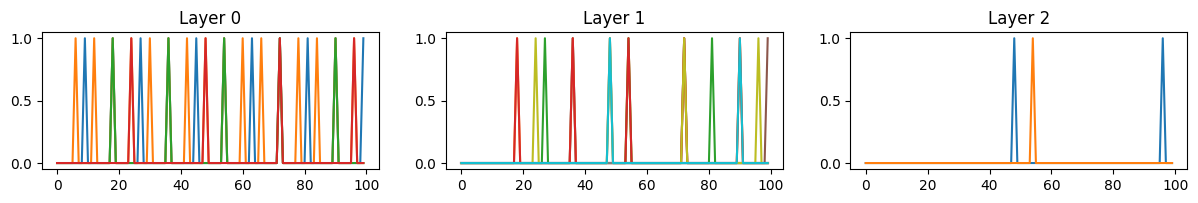

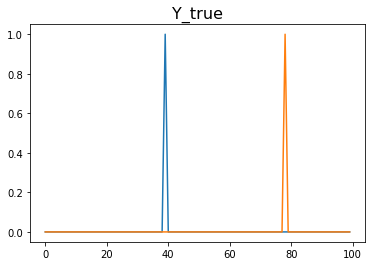

In [0]:
import multiprocessing as mp
output = mp.Queue()
import time

#Genetic algorithm parameters
sol_per_pop = 25
num_parents_mating = 8
num_generations = 50
mutation_percent = 20
ga = GA()

#Neuron parameters
input_dim=4
neurons_per_layer=[10,2]
num_synapses = np.product(neurons_per_layer) + neurons_per_layer[0]*input_dim
threshold=0.1
Cm=5

#initial population :       
population_vectors = np.random.uniform(0, 1.5,size=(sol_per_pop, num_synapses))

best_train_error, best_test_error = [], []
pop_train_error, pop_test_error = [], []

for generation in range(num_generations):
    start_time = time.time()
    #Calculate fitness for each population_vector in population    
    #send population vector for each process with id at -1 position

    temp_population_vectors = np.hstack((population_vectors, np.arange(sol_per_pop).reshape(sol_per_pop,1)))
    
    processes=[]
    for syn in temp_population_vectors:
        p = mp.Process(target = mp_fitness, args=(syn, output))
        processes.append(p)
    for p in processes:
        p.start()
    for p in processes:
        p.join()
    results = [output.get() for p in processes]
    results = np.asarray(results)
    results = results[np.argsort(results[:,0])]     #Arrange according to id 
    results = results[:, 1:]                        #remove ids from first column

    fitness_train, fitness_test = [], []
    for r in results:
        fitness_train.append(r[0])
        fitness_test.append(r[1])

    #Select best parents 
    parents = ga.select_mating_pool(population=population_vectors, fitness=fitness_train.copy(), mode='min', num_parents=num_parents_mating)
    #print(parents.shape[0],'New parents generated...')

    #Crossover parents
    offsprings = ga.crossover(parents=parents, num_offsprings=sol_per_pop-num_parents_mating)
    #print(offsprings.shape[0],'New offsprings produced...')
    
    #Mutate offsprings
    mutated_offsprings = ga.mutate(offsprings=offsprings, perturbation_range=[-1.0,1.0], mutation_percent=mutation_percent, mode='same')
    #print(mutated_offsprings.shape[0],'offsprings mutated')
    
    #Create new population
    population_vectors[:parents.shape[0],:] = parents
    population_vectors[parents.shape[0]:,:] = mutated_offsprings
    #print('New population created')
    
    print('============================================================================')
    print("Generation : ", generation+1,'/',num_generations)
    print('============================================================================')    
    best_train_error.append(fitness_train[0])                   #Mean error by best parameters
    best_test_error.append(fitness_test[0])                     #mean error by best parameters
    plt.plot(best_train_error)
    plt.plot(best_test_error)
    plt.show()           
    print('Mean Train Error by best parameters found:', best_train_error[-1])
    print('Mean Test Error by best parameters found:', best_test_error[-1])
    print()     
    #Update the result of this generation in report files
    '''
    f = open('/content/drive/My Drive/Final_year_project/NLOS_data/SNN_GA/train_error.pkl','wb')
    pickle.dump(best_train_error, f)
    f.close()
    f = open('/content/drive/My Drive/Final_year_project/NLOS_data/SNN_GA/test_error.pkl','wb')
    pickle.dump(best_test_error, f)
    f.close() 
    '''       
    f = open('/content/drive/My Drive/Final_year_project/NLOS_data/SNN_GA/(3)best_paramater_found.pkl','wb')
    pickle.dump(parents[0], f)
    f.close()
    
    pop_train_error.append(np.mean(fitness_train))              #Mean error by whole population
    pop_test_error.append(np.mean(fitness_test))                #mean error by whole population
    print('Mean Train Error by entire population:', pop_train_error[-1])
    print('Mean Test Error by entire population:', pop_test_error[-1])
    print('Computation Time taken: ',time.time()-start_time)
    print()
    print('Random evaluation by best parameter found so far:')
    random_evaluate(vector=parents[0], input_dim=input_dim, neurons_per_layer=neurons_per_layer, threshold=threshold, Cm=Cm)